# Time Series Analysis Final Project

Joshua Grou, Mark Niewierowski, Mez Edoka, Ted Steffens

In [127]:
import numpy as np
from statsmodels.tsa.arima_process import arma_acf
from statsmodels.tsa.arima_process import arma_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as LBtest
from matplotlib import pyplot as plt
import pandas as pd
import scipy.optimize
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
import pmdarima
import seaborn as sns

In [128]:
def evaluate_residuals(residuals):
    #check the QQ plot
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()
    #run shapiro-wilks test
    shap = shapiro(residuals)
    print("p-value from the shapiro-wilks test: " + str(shap[1]))
    if shap[1] < 0.05:
        print("The p value of the shapiro wilks test indicates significant evidence against normal")
    else:
        print("The p value of the shapiro wilks test does not indicate significant evidence against normal")
    #runs test
    runs_res = runstest_1samp(residuals)

    print("Runs test p value: " + str(runs_res[1]))
    if runs_res[1] < 0.05:
        print("The p value of the runs test indicates significant evidence against random")
    else:
        print("The p value of the runs test does not indicate significant evidence against random")

    plot_acf(residuals)
    plt.show()

    lb_res = LBtest(residuals)
    plt.plot(lb_res['lb_pvalue'])
    plt.axhline(0.05, color='r')
    plt.title("Ljung-Box Test p-Values")
    plt.xlabel("Trial")
    plt.ylabel("p-Value")
    plt.show()

    print("Results from Ljung-Box Test: \n")
    print(lb_res)

    return

In [147]:
def prediction(res_pmd):
    preds_df = (res_pmd
            .get_prediction(start=205, end=235)
            .summary_frame(alpha=0.05)
               )
    print(preds_df.head())
    # Plot the training data, predicted means and confidence intervals
    fig, ax = plt.subplots(figsize=(10,5))
    ax = yearly_spots.plot(label='Original Series')
    ax.set(
        title='True and Predicted Values, with Confidence Intervals',
        xlabel='Time',
        ylabel='Actual / Predicted Values'
    )
    preds_df['mean'].plot(ax=ax, style='r', label='Predicted Mean')
    ax.fill_between(
        preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
        color='r', alpha=0.1
    )
    legend = ax.legend(loc='upper left')
    return

## Data Set 1

Monthly Shampoo Sales

### Check For Stationarity

C:\Users\Theodore Steffens\AppData\Local\Temp\ipykernel_16092\3402648027.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = shampoo.pivot("Month", "Year", "Sales")


<Axes: xlabel='Year', ylabel='Month'>

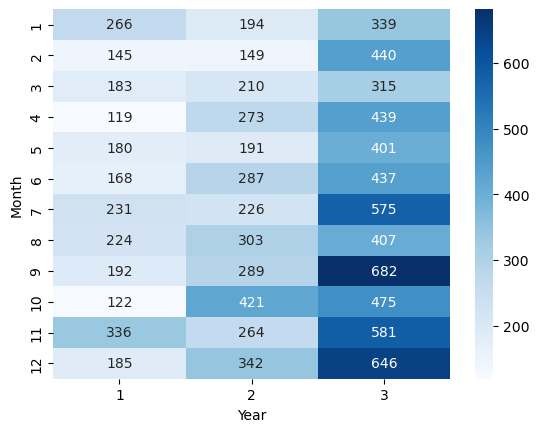

In [129]:
shampoo = pd.read_csv("shampoo.csv")

shampoo['Year']=shampoo['Month'].astype(str).str[0]
shampoo['Month']=shampoo['Month'].str[-2:]

shampoo['Year'] = shampoo['Year'].astype(int)
shampoo['Month'] = shampoo['Month'].astype(int)
shampoo['Sales'] = shampoo['Sales'].astype(int)
df = shampoo.pivot("Month", "Year", "Sales")
plt.figure()
sns.heatmap(df, fmt='d',annot=True, cmap='Blues')



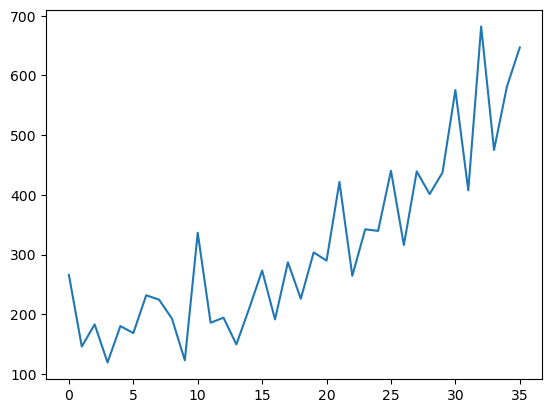

In [130]:
shampoo = pd.read_csv("shampoo.csv")
shampoo = shampoo["Sales"]
plt.plot(shampoo)
plt.show()

From observation the data set does not appear to be stationary, however we should perform the Dickey Fuller Test to confirm.

In [131]:
ad_fuller_res = adfuller(shampoo)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

p-value from the Augmented Dickey Fuller Test with software selected lags: 1.0


The Augmented Dickey Fuller Test returns a p-value of 1, this is a strong indication that the dataset, as suspected, is not stationary and thus we will need to use some techniques to introduce stationarity to the dataset.

### Transform the dataset to stationary

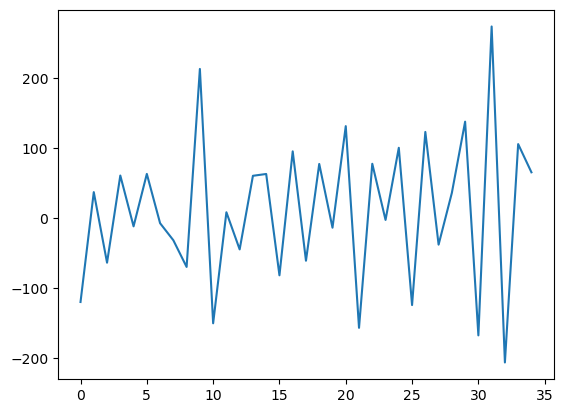

p-value from the Augmented Dickey Fuller Test with software selected lags: 1.7998574141687034e-10


In [132]:
first_dif = np.diff(shampoo)

plt.plot(first_dif)
plt.show()

ad_fuller_res = adfuller(first_dif)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

After applying the first difference the Augmented Dickey Fuller test shows that the dataset has been transformed to stationary.

### Investigate the ACF, PACF, and EACF

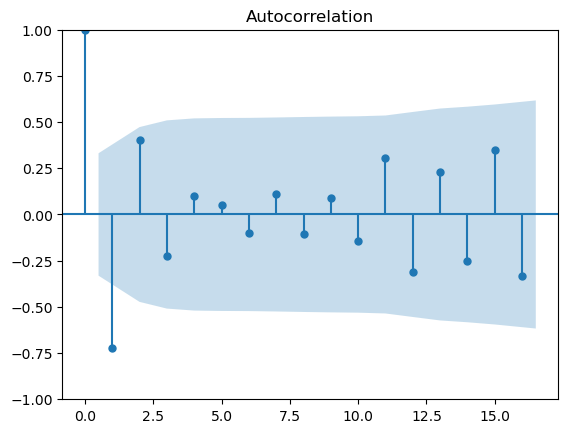

In [133]:
plot_acf(first_dif)
plt.show()

The ACF plot shows that only the first lag is significant in the data, however the second lag could be considered as it is very close to the boundary.

C:\Users\Theodore Steffens\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


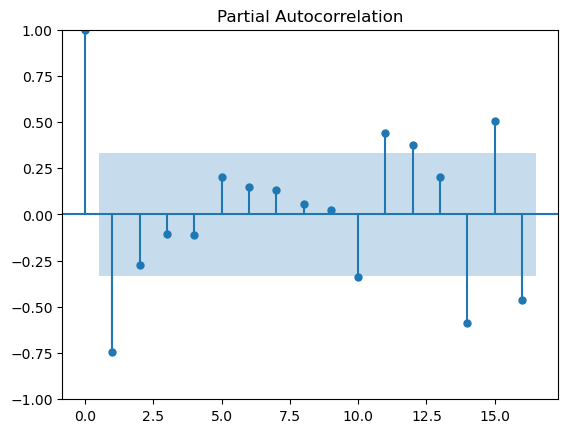

In [134]:
plot_pacf(first_dif, lags=16)
plt.show()

The PACF shows the first lag is significant, however we can observe that it is not really dropping off as would be expected but rather it is dieing out slowly in a sine manner.

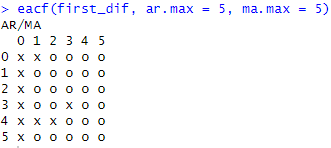

By finding the vertex of a triangle formed by the EACF plot it looks like ARMA(1,1)

By exploring the ACF, PACF, and EACF plots we have suggestions on the differenced dataset we have suggestions for IMA(1,1), IMA(1,2), and ARIMA(1,1,1). In addition to these suggestions we can also use the software package to help identify a model that has best AIC and BIC.

### Fitting the IMA(1,1) model

In [135]:
model_ima = sm.tsa.SARIMAX(shampoo, order=(0,1,1))
res_ima = model_ima.fit()

print(res_ima.summary())

resid_ima = res_ima.resid
preds = res_ima.predict(1,36)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -204.563
Date:                Thu, 13 Apr 2023   AIC                            413.125
Time:                        16:15:52   BIC                            416.236
Sample:                             0   HQIC                           414.199
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5924      0.176     -3.367      0.001      -0.937      -0.248
sigma2      6904.9685   1640.390      4.209      0.000    3689.862    1.01e+04
Ljung-Box (L1) (Q):                   6.70   Jarque-

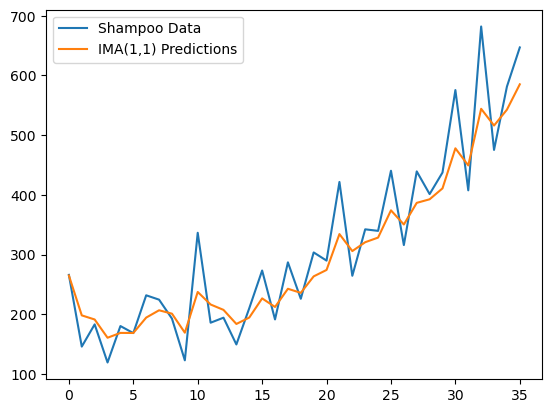

In [136]:
preds = preds.reset_index(drop = True)

plt.plot(shampoo)
plt.plot(preds)
plt.legend(["Shampoo Data", "IMA(1,1) Predictions"])
plt.show()

Viewing the model values against the actual the fit appears to be reasonable, however there are some peaks in the model that are not captured here. Next we will investigagte the residuals.

### Residual Analysis for IMA(1,1) Model

#### Test For Normality

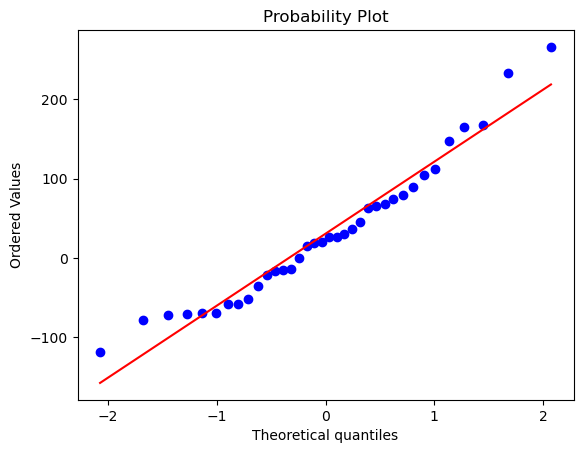

p-value from the shapiro-wilks test: 0.13012586534023285
The p value of the shapiro wilks test does not indicate significant evidence against normal
Runs test p value: 0.0367138563627041
The p value of the runs test indicates significant evidence against random


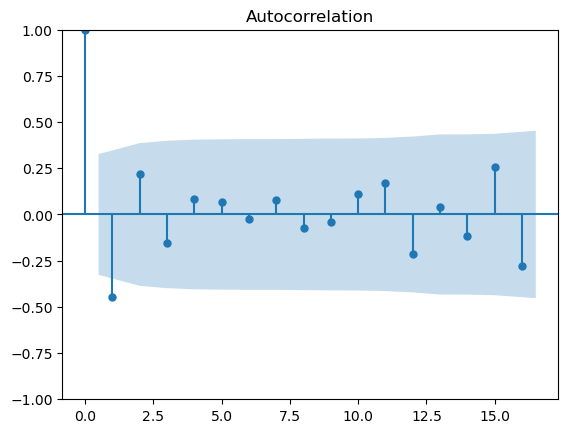

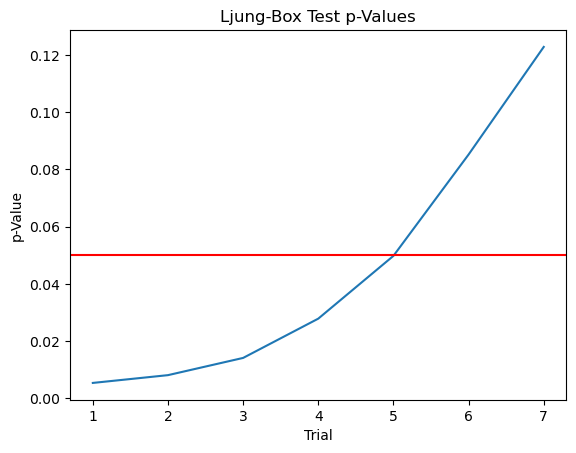

Results from Ljung-Box Test: 

     lb_stat  lb_pvalue
1   7.754871   0.005357
2   9.638005   0.008075
3  10.599938   0.014098
4  10.889642   0.027833
5  11.081816   0.049782
6  11.104143   0.085211
7  11.381150   0.122836


In [137]:
evaluate_residuals(resid_ima)

The probability plot gives the appearance that the residuals are not normally distributed, next would be the Shapiro Wilks Test to confirm or deny the nrmality assumption.

The shapiro wilks test does not show that there is significant evidence to reject the null hypothesis that the data is coming from normal, thus we can say that the residuals are approximately normally distributed.

#### Test for random generation.

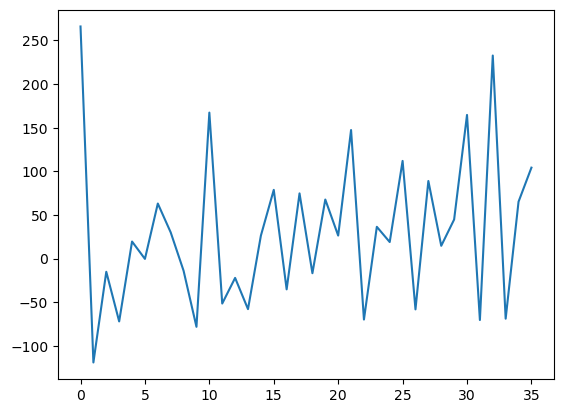

In [139]:
plt.plot(resid_ima)
plt.show()

The runs test shows enough evidence to reject the null hypothesis that the residuals were generated randomly. This may be an indication that there are uncaptured dependancies in the data.

#### Test for correlation among residuals

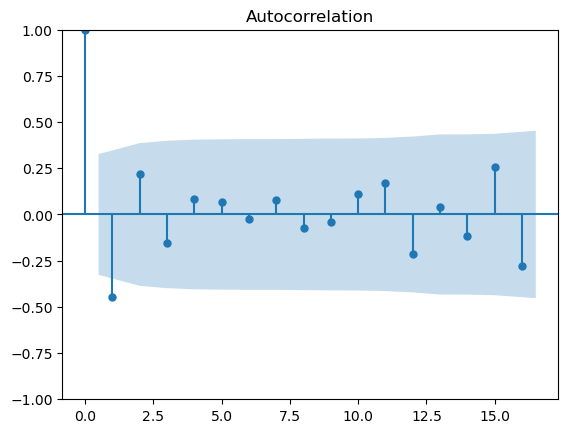

In [141]:
plot_acf(resid_ima)
plt.show()

In [142]:
lb_res = LBtest(resid_ima)

print("The p-values for the Ljung-Box test for the lags are:\n" + str(lb_res['lb_pvalue']))

The p-values for the Ljung-Box test for the lags are:
1    0.005357
2    0.008075
3    0.014098
4    0.027833
5    0.049782
6    0.085211
7    0.122836
Name: lb_pvalue, dtype: float64


By viewing the plot of the ACF we can see that the residuals may have some correlation because the first lag meets the significance threshold. By running the Ljung-Box Test we also see that it returns significant evidance of uncaptured dependance which indicates that the IMA(1,1) model may not be the best fit for the data set.

### Fitting the IMA(1,2) Model

In [143]:
model_ima = sm.tsa.SARIMAX(shampoo, order=(0,1,2))
res_ima = model_ima.fit()

print(res_ima.summary())

resid_ima = res_ima.resid
preds = res_ima.predict(1,36)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -196.730
Date:                Thu, 13 Apr 2023   AIC                            399.461
Time:                        16:16:21   BIC                            404.127
Sample:                             0   HQIC                           401.072
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3002      2.420     -0.537      0.591      -6.042       3.442
ma.L2          0.9940      3.683      0.270      0.787      -6.225       8.213
sigma2      3748.6601   1.37e+04      0.274      0.7

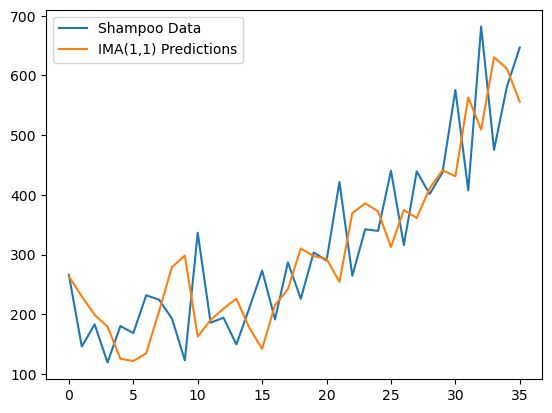

In [144]:
preds = preds.reset_index(drop = True)

plt.plot(shampoo)
plt.plot(preds)
plt.legend(["Shampoo Data", "IMA(1,1) Predictions"])
plt.show()

Here again the model seems to be a reasonable fit for the data, and appears to be more capturing of the peaks and dips than the IMA(1,1) model

### Residual analysis for IMA(1,2) model

#### Test for normality

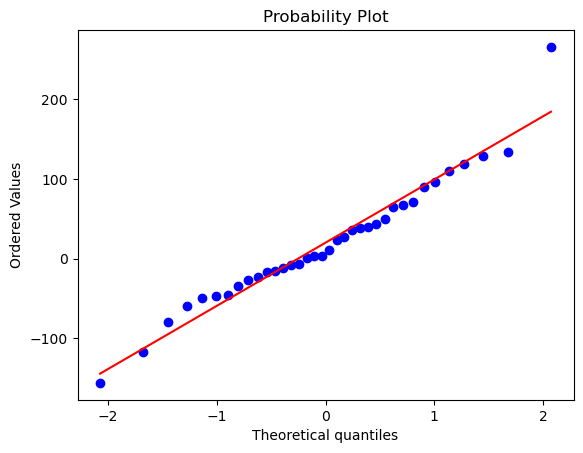

p-value from the shapiro-wilks test: 0.34869128465652466
The p value of the shapiro wilks test does not indicate significant evidence against normal
Runs test p value: 0.6240859056985628
The p value of the runs test does not indicate significant evidence against random


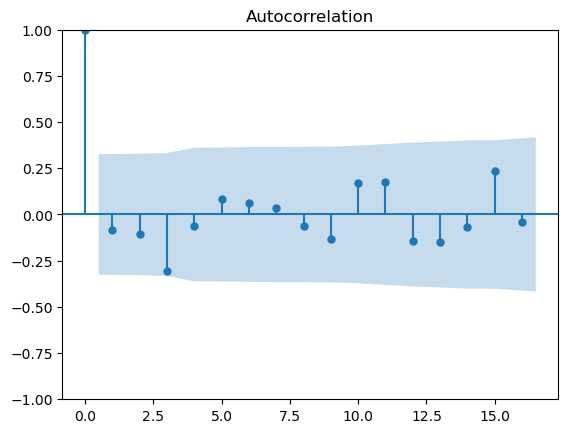

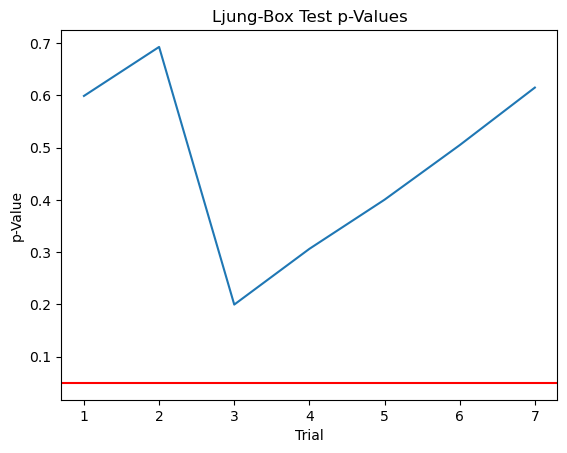

Results from Ljung-Box Test: 

    lb_stat  lb_pvalue
1  0.276902   0.598739
2  0.735035   0.692451
3  4.644078   0.199793
4  4.819010   0.306377
5  5.128902   0.400352
6  5.310273   0.504678
7  5.371656   0.614706


In [146]:
evaluate_residuals(resid_ima)

The QQ plot shows some evidence supporting the normal distribution, more so than the IMA(1,1) model.

The shaprio wilks test confirms this as we cannot reject the null hypothesis that the residuals are coming from normal distribution.

#### Test for random generation

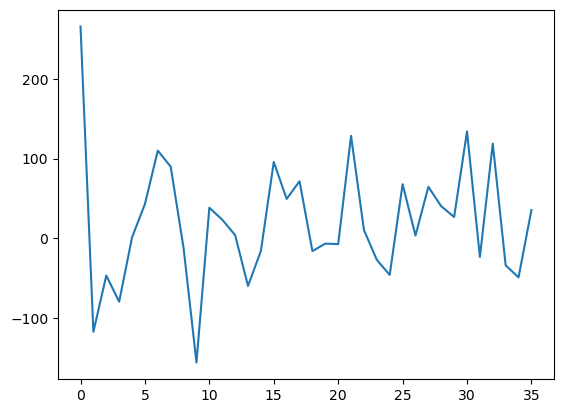

In [121]:
plt.plot(resid_ima)
plt.show()

The Runs test does not show sufficient evidence to reject the null hypothesis, thus we must accept that the residuals are generated randomly.

#### Test for uncaptured Dependancy.

### Fitting the ARIMA(1,1,1) Model

In [29]:
model_arima = sm.tsa.SARIMAX(shampoo, order=(1,1,1))
res_arima = model_arima.fit()

print(res_arima.summary())

resid_arima = res_arima.resid
preds = res_arima.predict(1,36)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -200.391
Date:                Thu, 13 Apr 2023   AIC                            406.782
Time:                        12:03:03   BIC                            411.448
Sample:                             0   HQIC                           408.393
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6003      0.201     -2.980      0.003      -0.995      -0.205
ma.L1         -0.2756      0.267     -1.033      0.302      -0.799       0.248
sigma2      5382.0425   1386.817      3.881      0.0

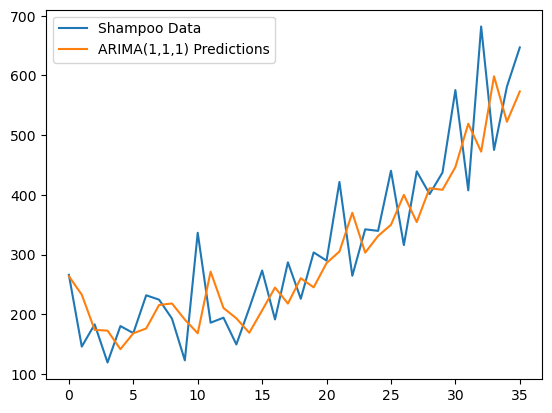

In [30]:
preds = preds.reset_index(drop = True)

plt.plot(shampoo)
plt.plot(preds)
plt.legend(["Shampoo Data", "ARIMA(1,1,1) Predictions"])
plt.show()

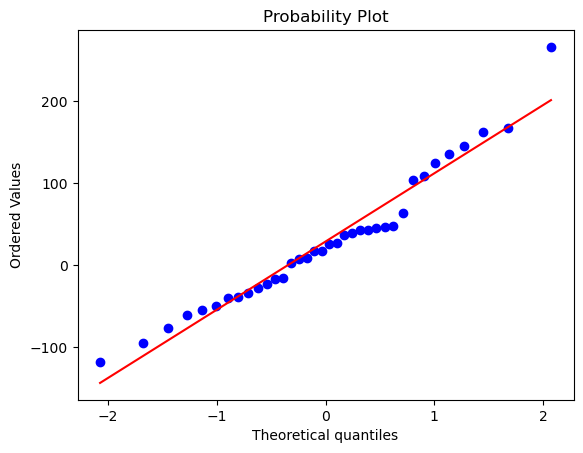

p-value from the shapiro-wilks test: 0.20880398154258728
The p value of the shapiro wilks test does not indicate significant evidence against normal
Runs test p value: 0.5552223043858198
The p value of the runs test does not indicate significant evidence against random


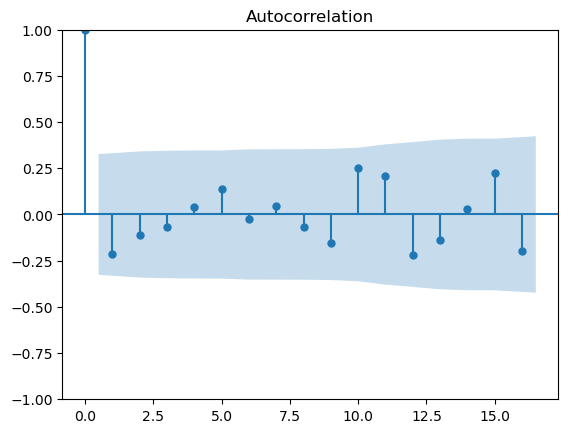

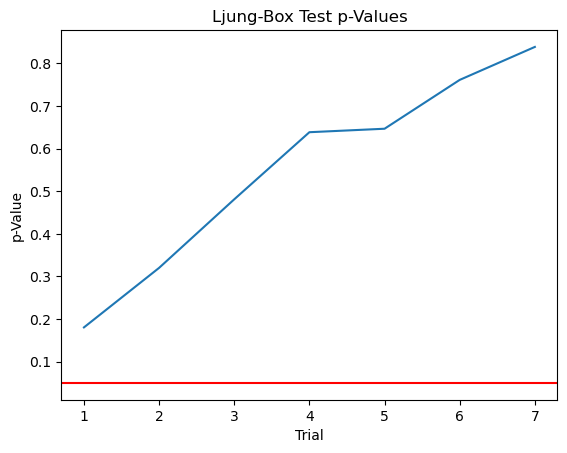

Results from Ljung-Box Test: 

    lb_stat  lb_pvalue
1  1.794527   0.180376
2  2.277932   0.320150
3  2.467840   0.481131
4  2.533385   0.638668
5  3.345857   0.646829
6  3.367502   0.761506
7  3.465032   0.838915


In [93]:
evaluate_residuals(resid_arima)

### Overfitting Model IMA(1,3)

In [32]:
model_ima = sm.tsa.SARIMAX(shampoo, order=(0,1,3))
res_ima = model_ima.fit()

print(res_ima.summary())

resid_ima = res_ima.resid
preds = res_ima.predict(1,36)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -196.634
Date:                Thu, 13 Apr 2023   AIC                            401.269
Time:                        12:03:05   BIC                            407.490
Sample:                             0   HQIC                           403.416
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2346      7.830     -0.158      0.875     -16.582      14.113
ma.L2          0.8891     11.186      0.079      0.937     -21.035      22.813
ma.L3          0.0823      1.240      0.066      0.9

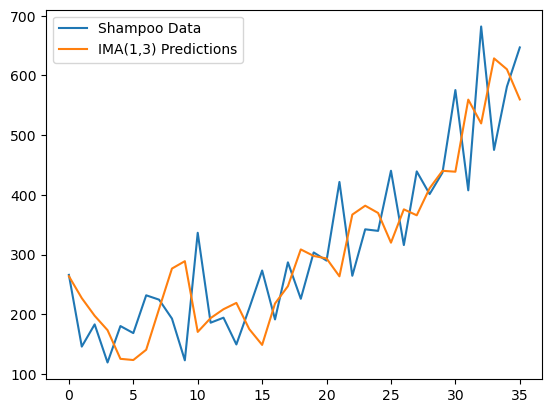

In [33]:
preds = preds.reset_index(drop = True)

plt.plot(shampoo)
plt.plot(preds)
plt.legend(["Shampoo Data", "IMA(1,3) Predictions"])
plt.show()

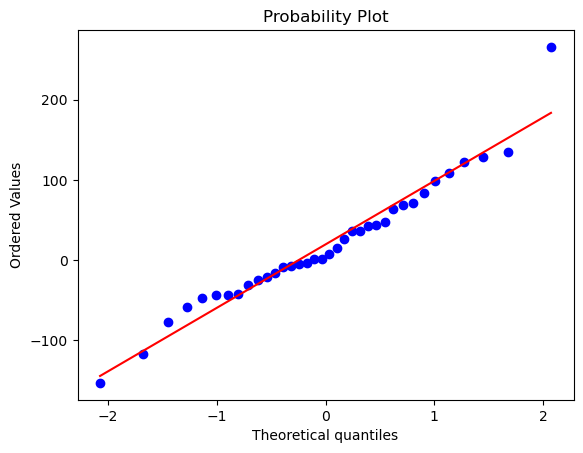

p-value from the shapiro-wilks test: 0.290724515914917
The p value of the shapiro wilks test does not indicate significant evidence against normal
Runs test p value: 0.6615987635795131
The p value of the runs test does not indicate significant evidence against random


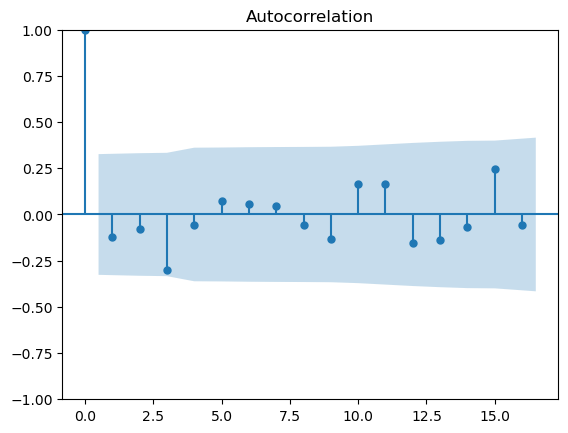

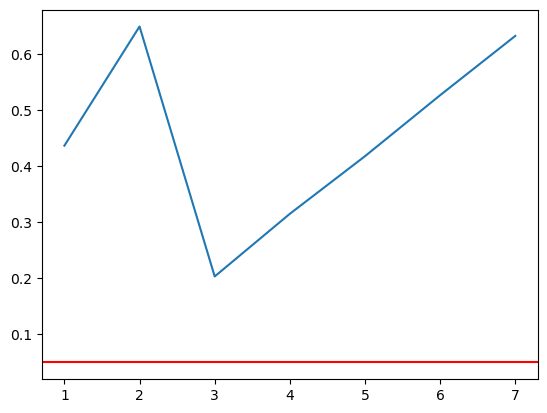

Results from Ljung-Box Test: 

    lb_stat  lb_pvalue
1  0.605874   0.436346
2  0.865571   0.648699
3  4.603235   0.203265
4  4.741150   0.314903
5  4.986083   0.417581
6  5.137964   0.526244
7  5.230144   0.631900


In [34]:
evaluate_residuals(resid_ima)

### Data Set 1 Conclusions

After fitting all of the models proposed by the ACF, PACF, and EACF plots we find that the IMA(1,2) model seems to be performing the best. This model has the lowest AIC and BIC, while having random, normally distributed, and un-correlated residuals. The ARIMA(1,1,1) model was comparable, having again random, normally distributed, and uncorrelated residuals, but the AIC and BIC are lower than the IMA(1,2) models.

To check for confirm the IMA(1,2) further an overfitting model was also created as IMA(1,3). From observing the parameters of this model we can see that the MA(3) parameter is close to zero and its inclusion does not much change the MA(1) and MA(2) parameters from the IMA(1,2) fit. This is an indication that going to IMA(1,3) would be overfitting and that IMA(1,2) is a good selection.

## Data Set 2

monthly sunspots

        Month  Sunspots
2810  1983-03      66.5
2811  1983-04      80.7
2812  1983-05      99.2
2813  1983-06      91.1
2814  1983-07      82.2
2815  1983-08      71.8
2816  1983-09      50.3
2817  1983-10      55.8
2818  1983-11      33.3
2819  1983-12      33.4


C:\Users\Theodore Steffens\AppData\Local\Temp\ipykernel_16092\86492399.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = spots.pivot("Month", "Year", "Sunspots")


<Axes: xlabel='Year', ylabel='Month'>

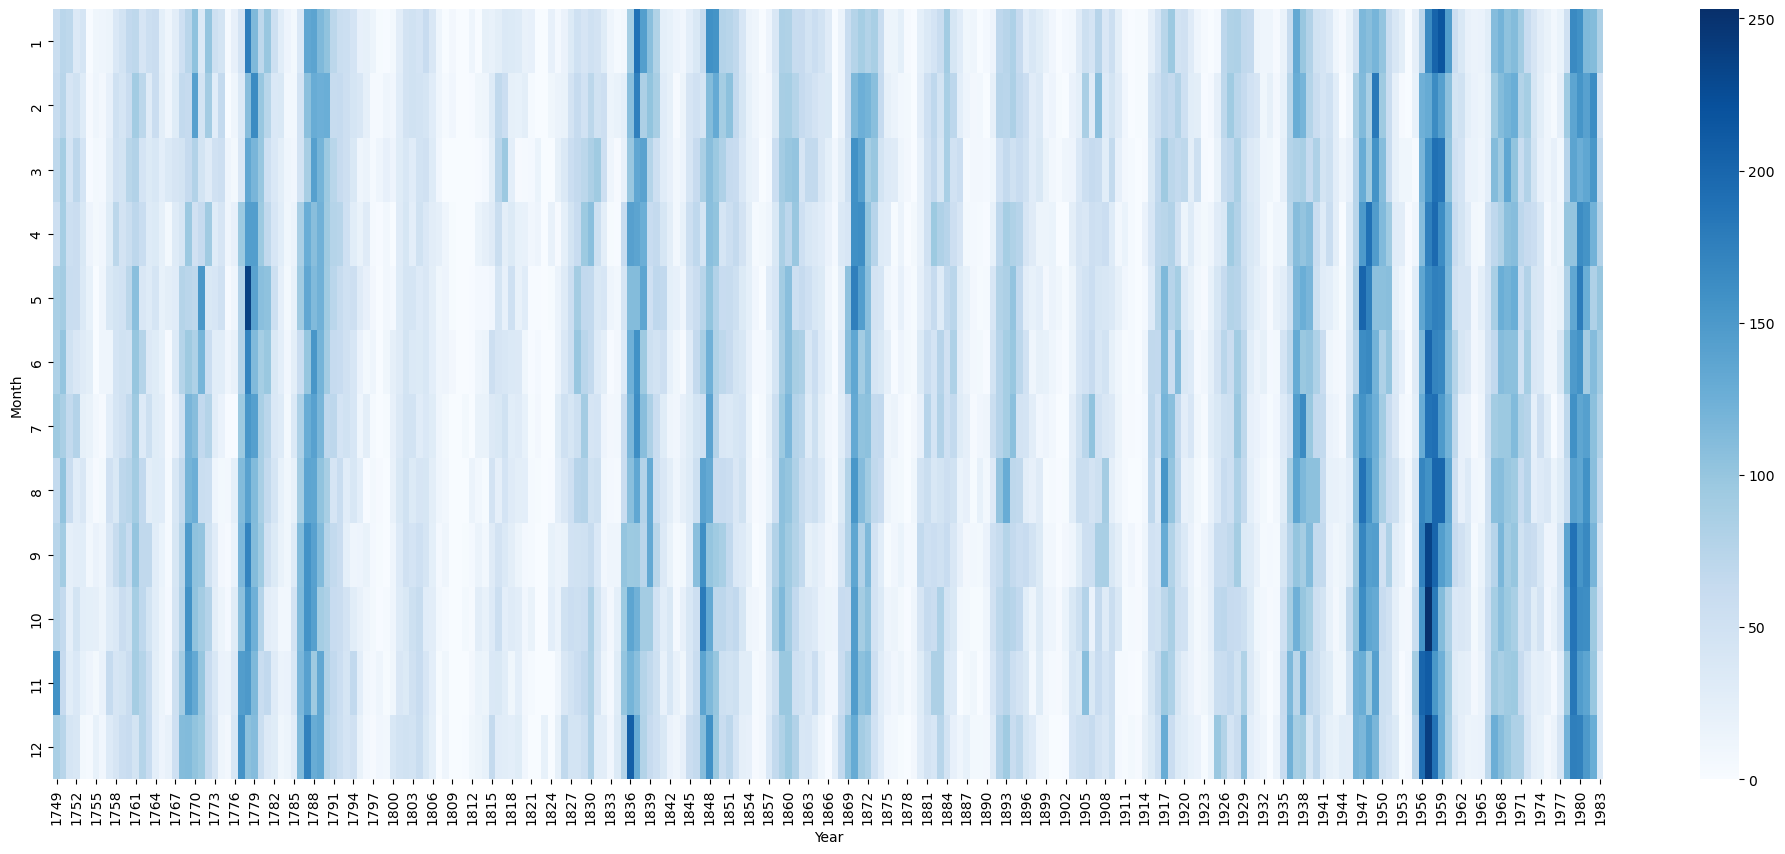

In [58]:
spots = pd.read_csv("monthly-sunspots.csv")
print(spots.iloc[-10:])

spots['Year']=spots['Month'].astype(str).str[0:4]
spots['Month']=spots['Month'].str[-2:]

spots['Year'] = spots['Year'].astype(int)
spots['Month'] = spots['Month'].astype(int)
spots['Sunspots'] = spots['Sunspots'].astype(int)
df = spots.pivot("Month", "Year", "Sunspots")
plt.figure(figsize=(25,10))
sns.heatmap(df, fmt='d',annot=False, cmap='Blues')

        Month  Sunspots
2810  1983-03      66.5
2811  1983-04      80.7
2812  1983-05      99.2
2813  1983-06      91.1
2814  1983-07      82.2
2815  1983-08      71.8
2816  1983-09      50.3
2817  1983-10      55.8
2818  1983-11      33.3
2819  1983-12      33.4


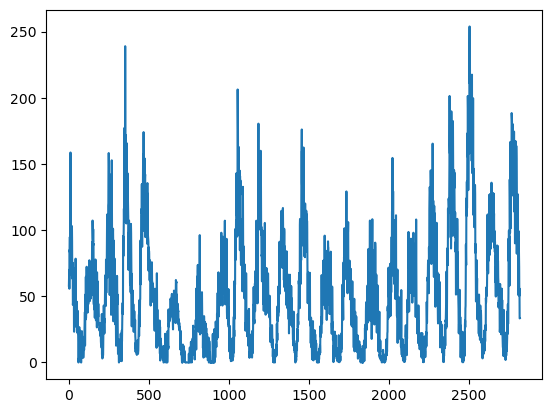

In [59]:
spots = pd.read_csv("monthly-sunspots.csv")
print(spots.iloc[-10:])
spots = spots["Sunspots"]
plt.plot(spots)
plt.show()

In [60]:
ad_fuller_res = adfuller(spots)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

p-value from the Augmented Dickey Fuller Test with software selected lags: 2.333452143866187e-16


The data set is showing as stationary from the Dickey Fuller test, however there is a very strong seasonality oberseved here that will need to be inspected.

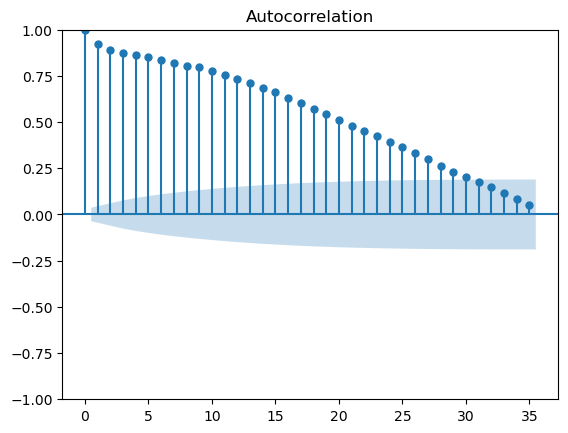

In [61]:
plot_acf(spots)
plt.show()

C:\Users\Theodore Steffens\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


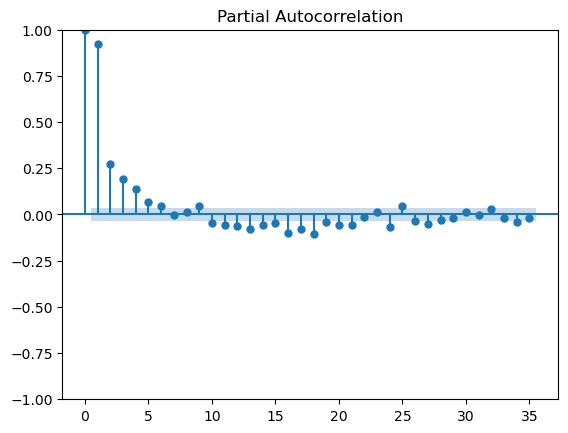

In [62]:
plot_pacf(spots)
plt.show()

Here we don't really get anything of value as the sample size is too large, we can try to aggregate by year rather than monthly.

In [63]:
spots = pd.read_csv("monthly-sunspots.csv")
spots["Month"] = spots["Month"].astype("datetime64")
yearly = spots.groupby(spots['Month'].dt.year)['Sunspots'].agg(['mean'])

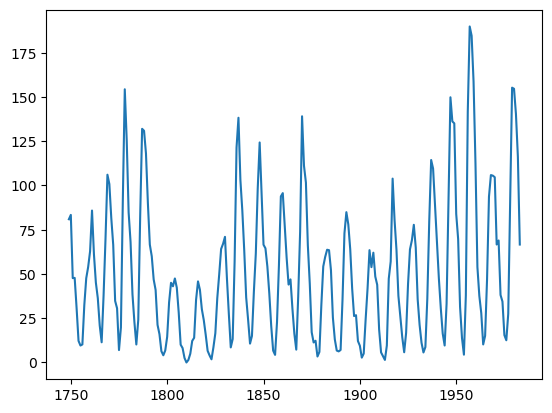

In [64]:
plt.plot(yearly)
plt.show()

In [65]:
yearly_spots = yearly["mean"]

ad_fuller_res = adfuller(yearly_spots)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

p-value from the Augmented Dickey Fuller Test with software selected lags: 0.14753205186316148


The yearly aggregated data shows as not stationary according to the dickey fuller test, so we will need to apply some transformations to make it stationary.

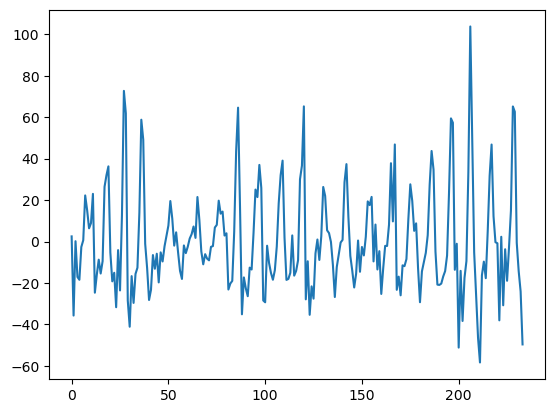

In [66]:
diff = np.diff(yearly_spots, 1)
plt.plot(diff)
plt.show()

In [67]:
ad_fuller_res = adfuller(diff)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

p-value from the Augmented Dickey Fuller Test with software selected lags: 2.4638076110444357e-22


After taking the first difference the data is shown as stationary by the augmented dickey fuller test.

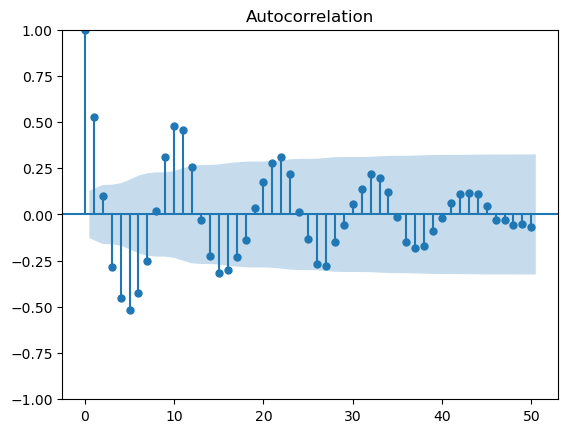

In [68]:
plot_acf(diff, lags = 50)
plt.show()

C:\Users\Theodore Steffens\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


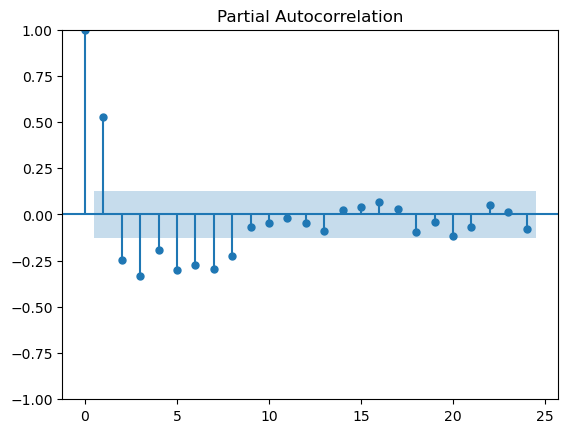

In [69]:
plot_pacf(diff)
plt.show()

From the ACF and PACF plots some reasonable options appear to be SARIMA(3,1,1)x(0,1,3)5, SARIMA(3,1,1)x(0,1,2)5 SARIMA(8,1,1)x(0,1,3)5, and SARIMA(8,1,1)x(0,1,2)5

### SARIMA (3,1,1)x(0,1,3)5

In [70]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]

model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(3,1,1), seasonal_order=(0,1,3,5), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())
resid_pmd = res_pmd.resid

C:\Users\Theodore Steffens\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                         SARIMAX Results                                         
Dep. Variable:                                      mean   No. Observations:                  205
Model:             SARIMAX(3, 1, 1)x(0, 1, [1, 2, 3], 5)   Log Likelihood                -838.071
Date:                                   Thu, 13 Apr 2023   AIC                           1692.143
Time:                                           12:41:04   BIC                           1718.489
Sample:                                                0   HQIC                          1702.806
                                                   - 205                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1372      0.080     14.301      0.000    

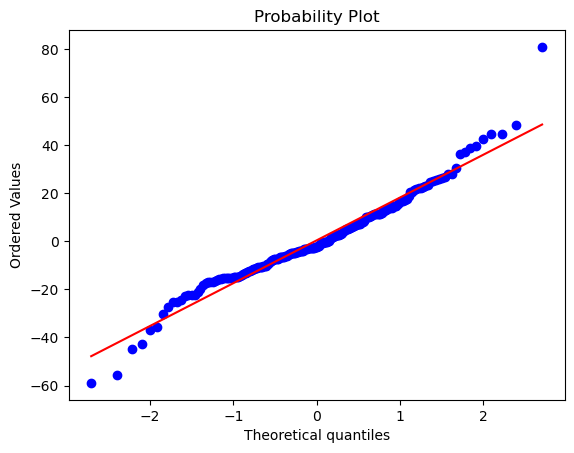

p-value from the shapiro-wilks test: 7.806299981893972e-05
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.1561688108110983
The p value of the runs test does not indicate significant evidence against random


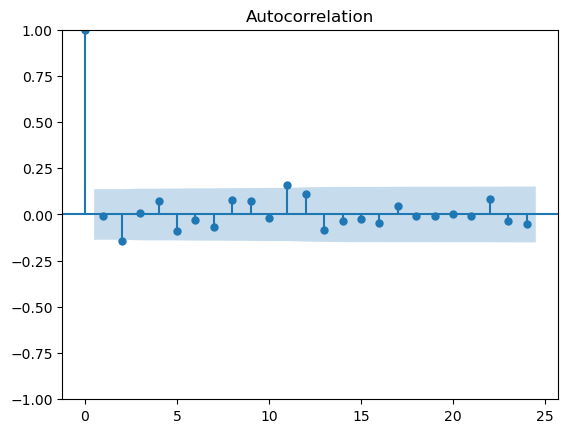

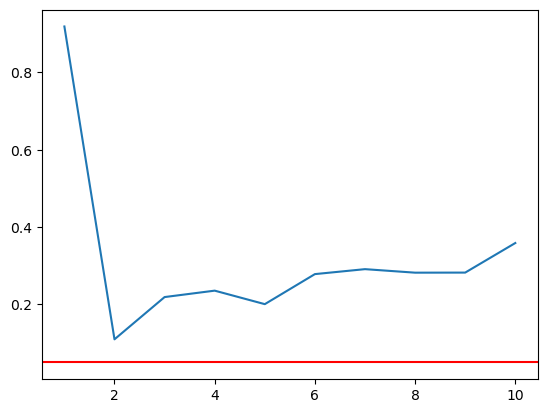

Results from Ljung-Box Test: 

      lb_stat  lb_pvalue
1    0.010407   0.918744
2    4.416949   0.109868
3    4.424575   0.219117
4    5.546031   0.235713
5    7.277571   0.200802
6    7.482994   0.278477
7    8.490963   0.291296
8    9.761063   0.282198
9   10.903094   0.282410
10  10.982884   0.358853


In [71]:
evaluate_residuals(resid_pmd)

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205    16.950392  15.608882     -13.642455      47.543239
206    35.831460  24.956088     -13.081573      84.744493
207    68.223922  31.263886       6.947831     129.500013
208    96.518587  33.683390      30.500355     162.536819
209   103.343763  33.983911      36.736521     169.951005


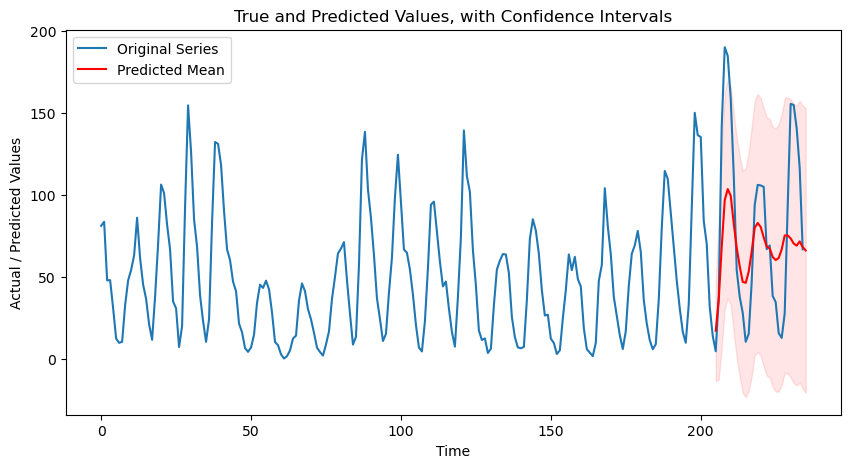

In [73]:
prediction(res_pmd)

### SARIMA (3,1,1)x(0,1,3)10

In [80]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]

model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(3,1,1), seasonal_order=(0,1,3,10), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())
resid_pmd = res_pmd.resid

                                         SARIMAX Results                                          
Dep. Variable:                                       mean   No. Observations:                  205
Model:             SARIMAX(3, 1, 1)x(0, 1, [1, 2, 3], 10)   Log Likelihood                -820.660
Date:                                    Thu, 13 Apr 2023   AIC                           1657.319
Time:                                            12:44:02   BIC                           1683.462
Sample:                                                 0   HQIC                          1667.905
                                                    - 205                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1152      0.086     13.007      0

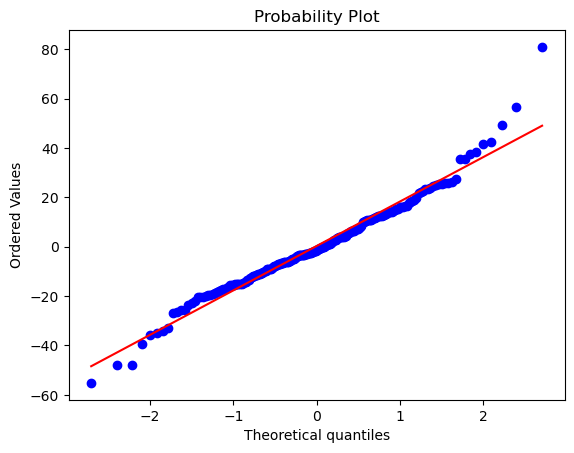

p-value from the shapiro-wilks test: 0.0005527809262275696
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.21492045567624374
The p value of the runs test does not indicate significant evidence against random


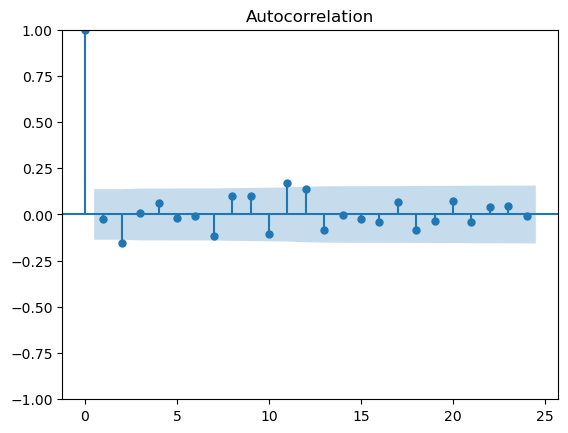

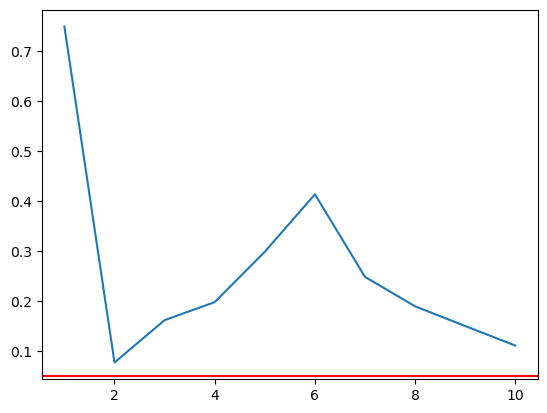

Results from Ljung-Box Test: 

      lb_stat  lb_pvalue
1    0.102753   0.748551
2    5.137714   0.076623
3    5.148370   0.161250
4    6.024903   0.197296
5    6.085368   0.298001
6    6.091977   0.412966
7    9.067987   0.247812
8   11.231874   0.188904
9   13.298627   0.149553
10  15.638445   0.110461


In [81]:
evaluate_residuals(resid_pmd)

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205    16.950392  15.608882     -13.642455      47.543239
206    35.831460  24.956088     -13.081573      84.744493
207    68.223922  31.263886       6.947831     129.500013
208    96.518587  33.683390      30.500355     162.536819
209   103.343763  33.983911      36.736521     169.951005


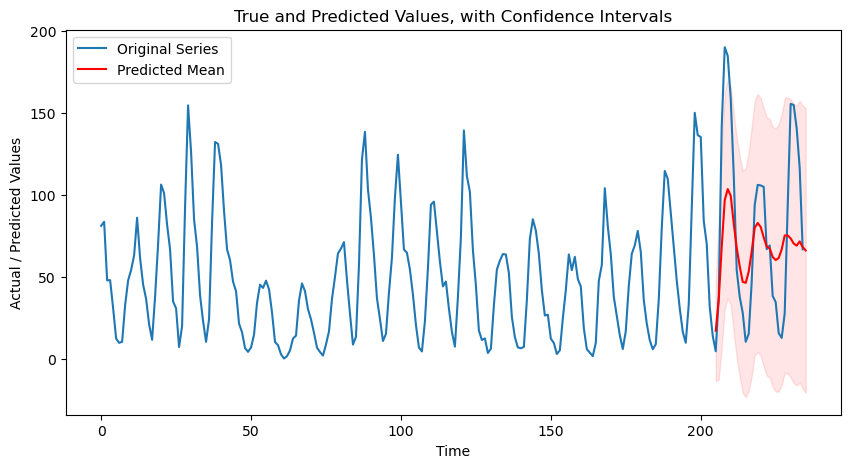

In [51]:
prediction(res_pmd)

### SARIMA (3,1,1)x(0,1,2)5

In [107]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]

model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(3,1,1), seasonal_order=(0,1,2,5), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())
resid_pmd = res_pmd.resid

                                       SARIMAX Results                                        
Dep. Variable:                                   mean   No. Observations:                  205
Model:             SARIMAX(3, 1, 1)x(0, 1, [1, 2], 5)   Log Likelihood                -838.533
Date:                                Wed, 12 Apr 2023   AIC                           1691.066
Time:                                        14:33:10   BIC                           1714.119
Sample:                                             0   HQIC                          1700.396
                                                - 205                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1488      0.080     14.374      0.000       0.992       1.305
ar.

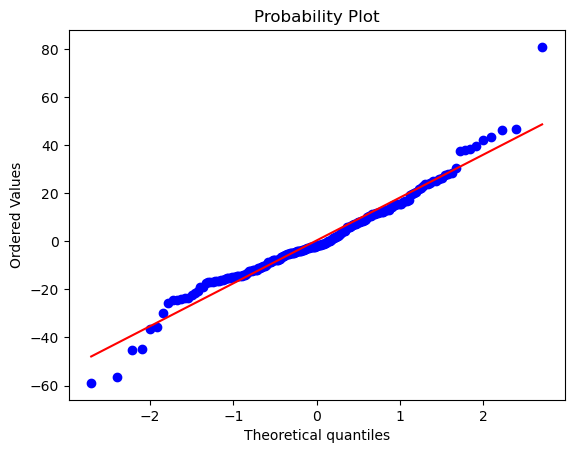

p-value from the shapiro-wilks test: 6.112240225775167e-05
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.09481206629582933
The p value of the runs test does not indicate significant evidence against random


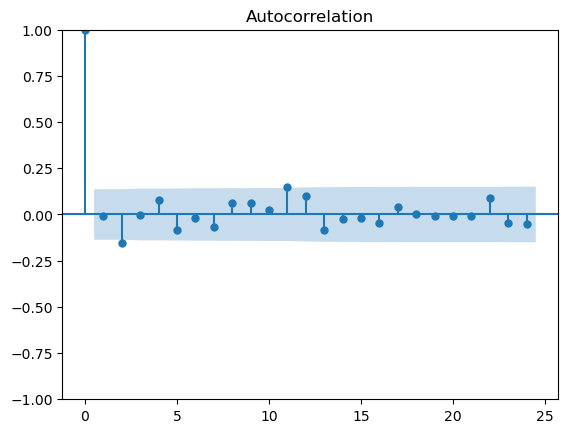

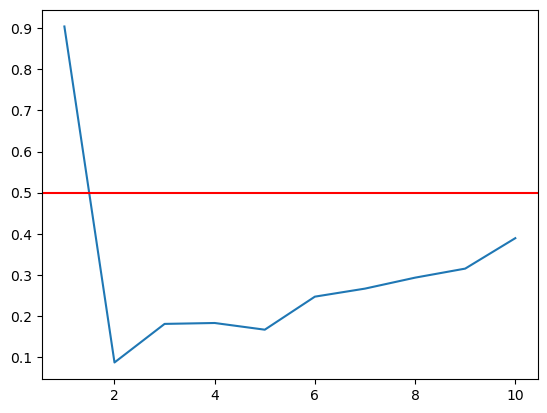

Results from Ljung-Box Test: 

      lb_stat  lb_pvalue
1    0.014621   0.903755
2    4.874313   0.087409
3    4.875550   0.181140
4    6.219583   0.183339
5    7.809162   0.167071
6    7.875622   0.247358
7    8.806206   0.266871
8    9.609552   0.293506
9   10.447601   0.315478
10  10.601011   0.389435


In [108]:
evaluate_residuals(resid_pmd)

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205    16.950392  15.608882     -13.642455      47.543239
206    35.831460  24.956088     -13.081573      84.744493
207    68.223922  31.263886       6.947831     129.500013
208    96.518587  33.683390      30.500355     162.536819
209   103.343763  33.983911      36.736521     169.951005


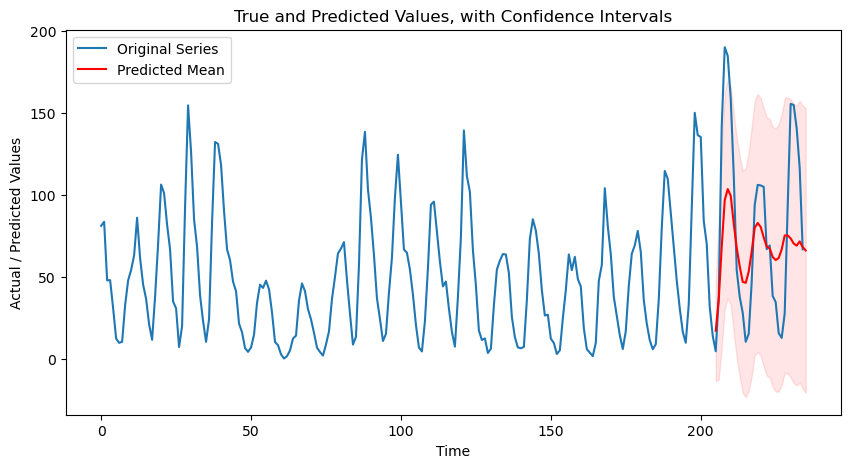

In [52]:
prediction(res_pmd)

### SARIMA (3,1,1)x(0,1,2)10

In [106]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]

model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(3,1,1), seasonal_order=(0,1,2,10), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())
resid_pmd = res_pmd.resid

                                        SARIMAX Results                                        
Dep. Variable:                                    mean   No. Observations:                  205
Model:             SARIMAX(3, 1, 1)x(0, 1, [1, 2], 10)   Log Likelihood                -820.670
Date:                                 Thu, 13 Apr 2023   AIC                           1655.340
Time:                                         13:32:19   BIC                           1678.215
Sample:                                              0   HQIC                          1664.603
                                                 - 205                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1150      0.085     13.128      0.000       0.949       1

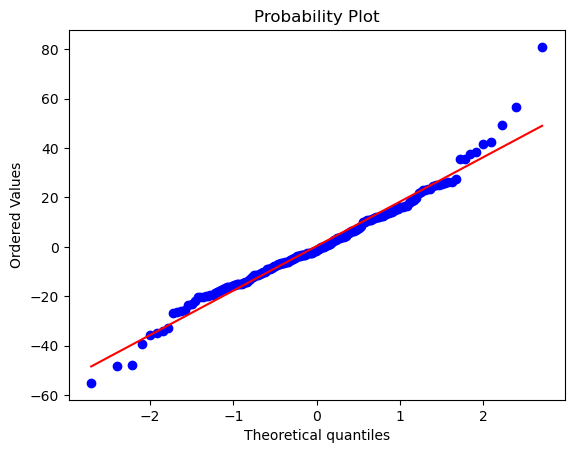

p-value from the shapiro-wilks test: 0.0005392523016780615
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.21492045567624374
The p value of the runs test does not indicate significant evidence against random


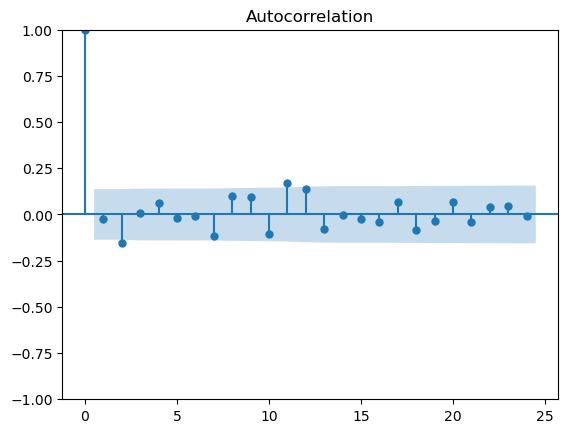

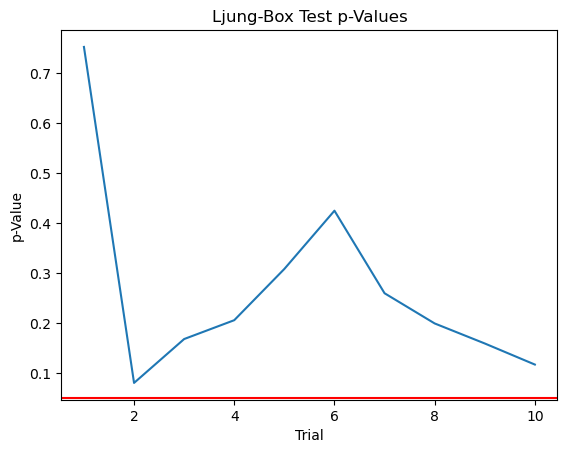

Results from Ljung-Box Test: 

      lb_stat  lb_pvalue
1    0.098962   0.753078
2    5.038836   0.080506
3    5.047499   0.168352
4    5.908739   0.206068
5    5.975088   0.308650
6    5.981646   0.425249
7    8.898512   0.260025
8   11.037484   0.199584
9   13.069626   0.159481
10  15.426642   0.117264


In [107]:
evaluate_residuals(resid_pmd)

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205    15.230976  15.779509     -15.696292      46.158244
206    36.051420  25.015357     -12.977778      85.080619
207    67.833563  30.900497       7.269702     128.397424
208   101.719893  33.153066      36.741078     166.698709
209   110.218439  33.499711      44.560212     175.876665


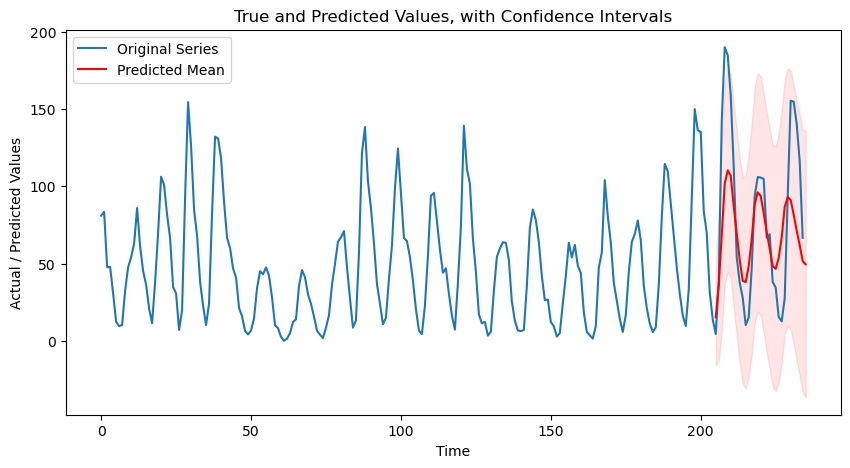

In [108]:
prediction(res_pmd)

### SARIMA (8,1,1)x(0,1,3)5

In [119]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]

model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(8,1,1), seasonal_order=(0,1,3,5), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())
resid_pmd = res_pmd.resid

c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                         SARIMAX Results                                         
Dep. Variable:                                      mean   No. Observations:                  205
Model:             SARIMAX(8, 1, 1)x(0, 1, [1, 2, 3], 5)   Log Likelihood                -828.913
Date:                                   Sun, 09 Apr 2023   AIC                           1683.826
Time:                                           18:22:20   BIC                           1726.639
Sample:                                                0   HQIC                          1701.154
                                                   - 205                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7363      0.516      1.427      0.153    

c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


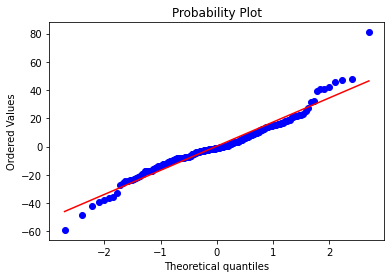

p-value from the shapiro-wilks test: 5.508661615749588e-06
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.41480999428001797
The p value of the runs test does not indicate significant evidence against random


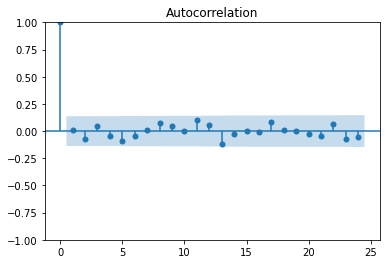

Results from Ljung-Box Test: 

     lb_stat  lb_pvalue
1   0.020425   0.886358
2   1.067640   0.586361
3   1.503296   0.681510
4   1.882433   0.757371
5   3.742558   0.587044
6   4.138138   0.657989
7   4.177552   0.759115
8   5.410902   0.712890
9   5.809610   0.758812
10  5.811703   0.830827


In [120]:
evaluate_residuals(resid_pmd)

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205    16.950392  15.608882     -13.642455      47.543239
206    35.831460  24.956088     -13.081573      84.744493
207    68.223922  31.263886       6.947831     129.500013
208    96.518587  33.683390      30.500355     162.536819
209   103.343763  33.983911      36.736521     169.951005


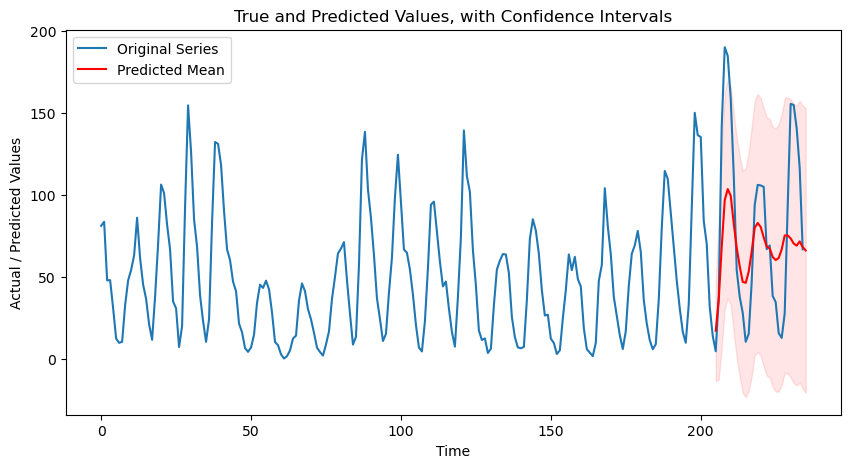

In [54]:
prediction(res_pmd)

### SARIMA (8,1,1)x(0,1,3)10

In [86]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]

model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(8,1,1), seasonal_order=(0,1,3,10), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())
resid_pmd = res_pmd.resid

                                         SARIMAX Results                                          
Dep. Variable:                                       mean   No. Observations:                  205
Model:             SARIMAX(8, 1, 1)x(0, 1, [1, 2, 3], 10)   Log Likelihood                -810.377
Date:                                    Thu, 13 Apr 2023   AIC                           1646.754
Time:                                            13:15:58   BIC                           1689.236
Sample:                                                 0   HQIC                          1663.956
                                                    - 205                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7540      0.363      2.077      0

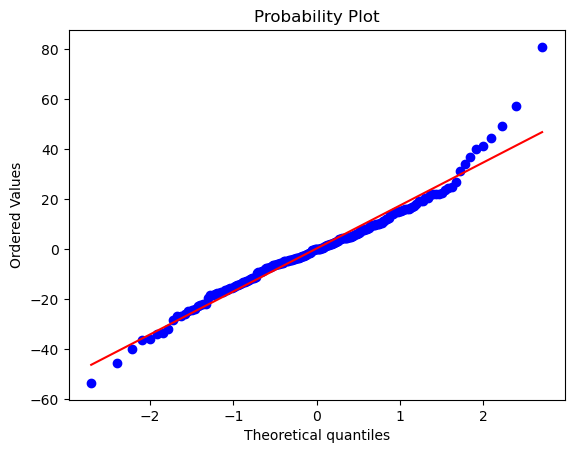

p-value from the shapiro-wilks test: 5.9417885495349765e-05
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.7134401662779102
The p value of the runs test does not indicate significant evidence against random


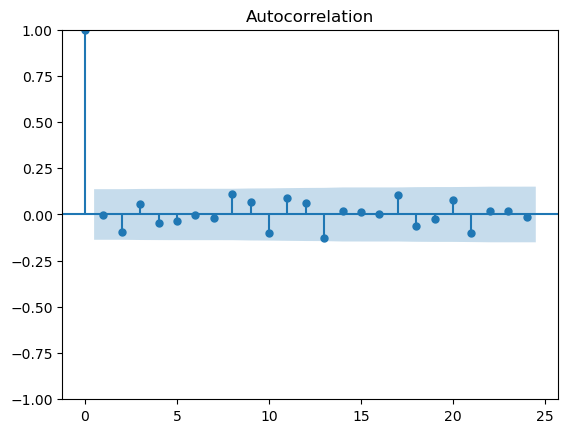

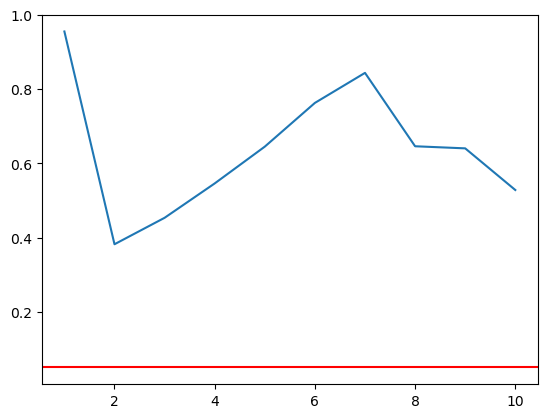

Results from Ljung-Box Test: 

     lb_stat  lb_pvalue
1   0.003180   0.955033
2   1.925124   0.381913
3   2.624771   0.453163
4   3.072601   0.545750
5   3.358676   0.644871
6   3.358978   0.762628
7   3.420896   0.843532
8   6.012291   0.645855
9   6.970322   0.640209
10  9.042811   0.528046


In [87]:
evaluate_residuals(resid_pmd)

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205     7.666465  14.877323     -21.492552      36.825481
206    36.603109  23.275565      -9.016159      82.222377
207    65.229078  27.978669      10.391894     120.066263
208   107.596014  29.219552      50.326744     164.865285
209   124.610292  29.501426      66.788560     182.432024


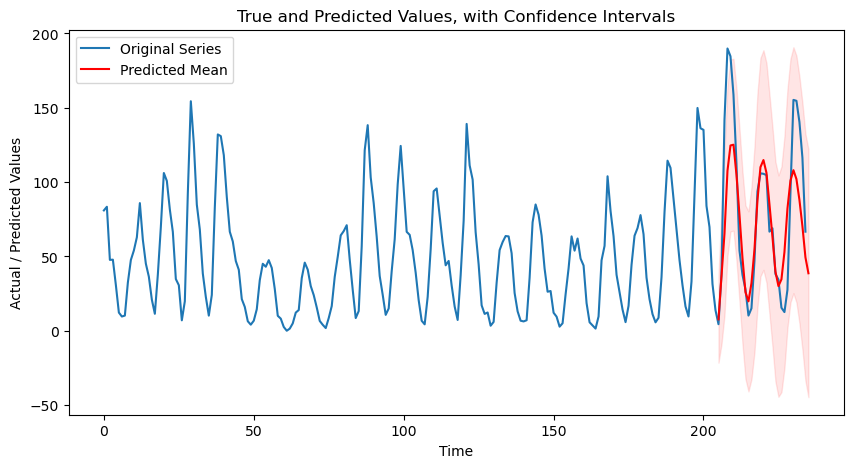

In [88]:
prediction(res_pmd)

### SARIMA(8,1,1)x(0,1,2)5

In [123]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]

model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(8,1,1), seasonal_order=(0,1,2,5), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())
resid_pmd = res_pmd.resid

                                       SARIMAX Results                                        
Dep. Variable:                                   mean   No. Observations:                  205
Model:             SARIMAX(8, 1, 1)x(0, 1, [1, 2], 5)   Log Likelihood                -829.141
Date:                                Sun, 09 Apr 2023   AIC                           1682.282
Time:                                        18:24:06   BIC                           1721.802
Sample:                                             0   HQIC                          1698.277
                                                - 205                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7718      0.476      1.620      0.105      -0.162       1.706
ar.

c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


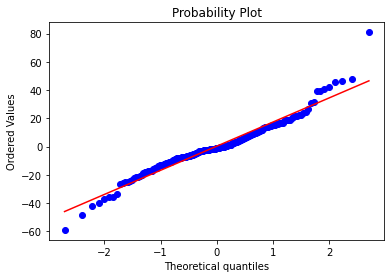

p-value from the shapiro-wilks test: 6.377266799972858e-06
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.287121643776418
The p value of the runs test does not indicate significant evidence against random


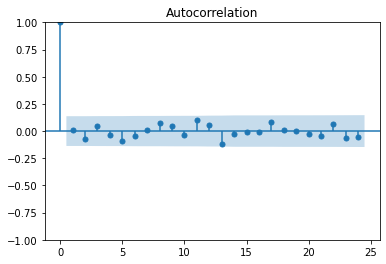

Results from Ljung-Box Test: 

     lb_stat  lb_pvalue
1   0.018707   0.891209
2   1.050033   0.591546
3   1.429555   0.698622
4   1.763224   0.779203
5   3.483303   0.625916
6   3.843594   0.697833
7   3.850741   0.796800
8   5.107962   0.745977
9   5.513308   0.787466
10  5.755719   0.835352


In [124]:
evaluate_residuals(resid_pmd)

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205    16.950392  15.608882     -13.642455      47.543239
206    35.831460  24.956088     -13.081573      84.744493
207    68.223922  31.263886       6.947831     129.500013
208    96.518587  33.683390      30.500355     162.536819
209   103.343763  33.983911      36.736521     169.951005


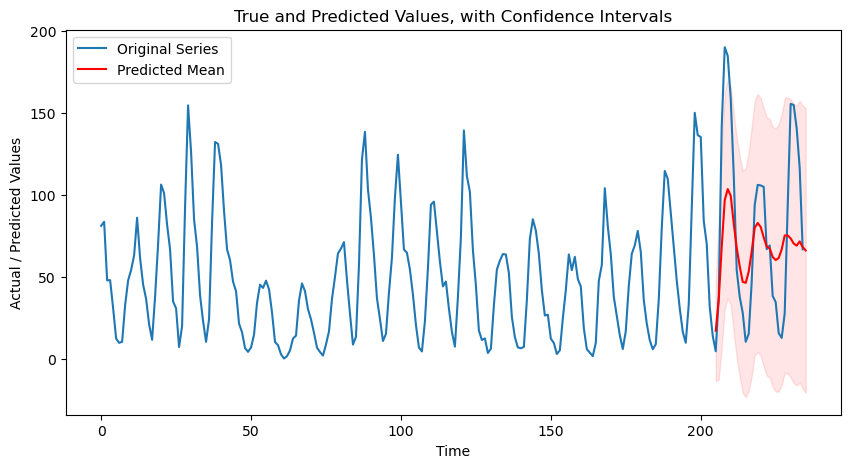

In [56]:
prediction(res_pmd)

### SARIMA(8,1,1)x(0,1,2)10

In [100]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]

model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(8,1,1), seasonal_order=(0,1,2,10), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())
resid_pmd = res_pmd.resid

                                        SARIMAX Results                                        
Dep. Variable:                                    mean   No. Observations:                  205
Model:             SARIMAX(8, 1, 1)x(0, 1, [1, 2], 10)   Log Likelihood                -811.040
Date:                                 Thu, 13 Apr 2023   AIC                           1646.079
Time:                                         13:31:26   BIC                           1685.294
Sample:                                              0   HQIC                          1661.958
                                                 - 205                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7729      0.330      2.339      0.019       0.125       1

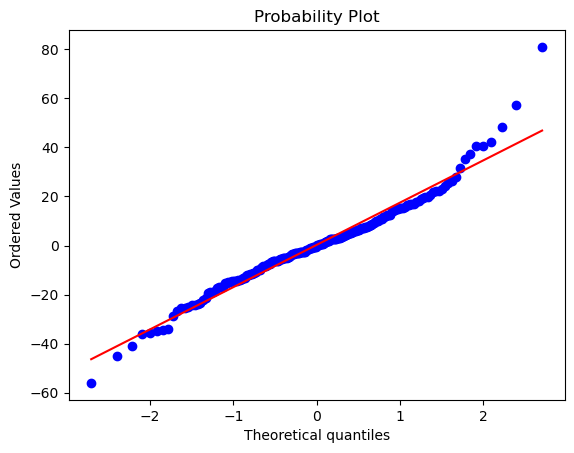

p-value from the shapiro-wilks test: 4.9908161599887535e-05
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.723920465699325
The p value of the runs test does not indicate significant evidence against random


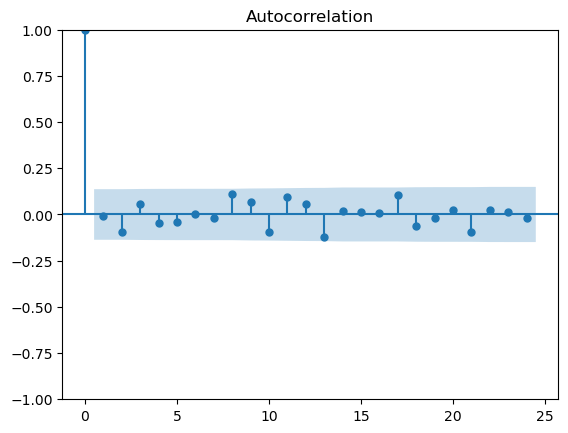

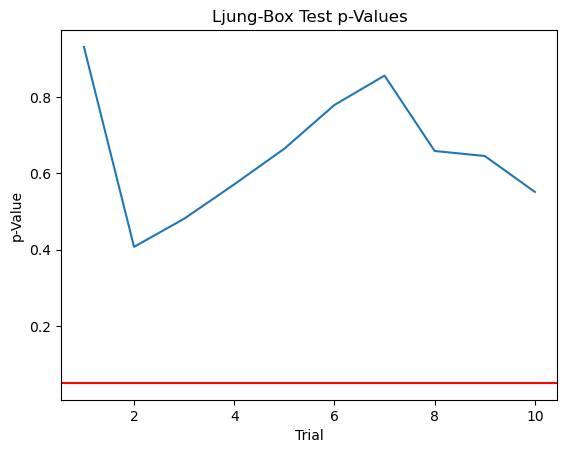

Results from Ljung-Box Test: 

     lb_stat  lb_pvalue
1   0.007232   0.932230
2   1.796456   0.407291
3   2.467617   0.481172
4   2.919876   0.571322
5   3.226728   0.665077
6   3.227266   0.779829
7   3.289974   0.856945
8   5.895051   0.658987
9   6.916052   0.645859
10  8.796512   0.551518


In [101]:
evaluate_residuals(resid_pmd)

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205     7.274649  15.000594     -22.125975      36.675272
206    36.760470  23.631230      -9.555890      83.076830
207    67.893413  28.457476      12.117785     123.669041
208   111.403561  29.710154      53.172730     169.634393
209   127.504095  29.971621      68.760798     186.247392


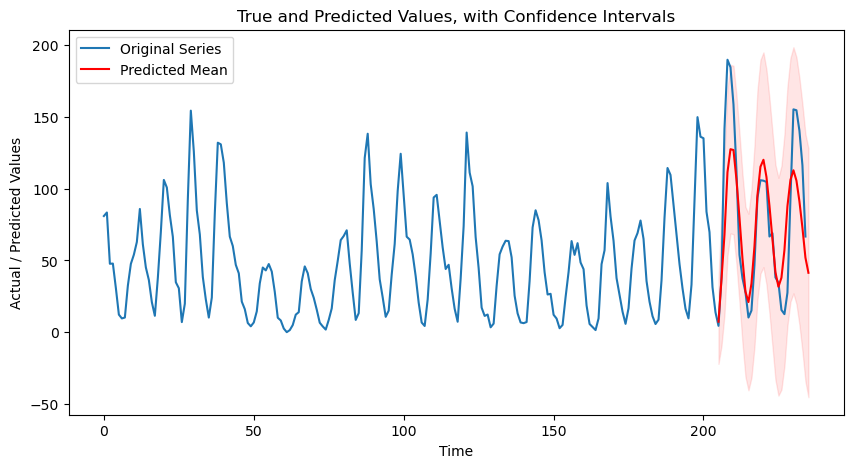

In [102]:
prediction(res_pmd)

From fitting these 4 choices of models and performing the residual analysis and forecasting on unused data we can find that all are doing a reasonable job. Under the principle of parsimony we should be preferring the SARIMA(3,1,1)x(0,1,2)5 model as it is the most simple in estimation. However when looking to the SARIMA(8,1,1)x(0,1,2)5 model we see there is an improvement in the AIC with a small penalty to BIC, and the test forecast is showing better agreement with the real curves than the SARIMA(3,1,1)x(0,1,2)5 model.

From the ACF and PACF Plot there are a lot of options that look reasonable, to find the best option we can use an iterative approach to solve for the models with the lowest BIC which is good for penalizing models that have excessive parameters.

We can use this approach with PMDARIMA auto_arima function which can help us to find the model with the lowest BIC score. To use this we do need to identify the differencing level required which is 1 according to the stationarity tests on the data, the next thing is to identify the seasonal period. From our ACF we can tell that the seasonal period should be 5 years. This information is required to be provided apriori to auto_arima.

Because we have many observations available we can segment the dataset into a training, validation, and testing dataset. The last 60 points will be split into 30 points for validation and 30 points for testing. This will allow us to see how well our model is forecasting out from the known data. By providing a validation set we are also able to have the auto-arima search looking for models that forecast well by measuring the MSE of each model on the next 30 data points.

In [119]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]
model = pmdarima.arima.auto_arima(y = yearly_spots_train, start_p = 1, d =1, start_q = 1, m=5, max_P = 4, max_Q = 5, D=1, out_of_sample_size=30, information_criterion='bic', maxiter= 1000)
print(model)
model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(3,1,0), seasonal_order=(3,1,1,5), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())

resid_pmd = res_pmd.resid
preds = res_pmd.predict(1,235)

 ARIMA(3,1,0)(3,1,1)[5]          
                                      SARIMAX Results                                      
Dep. Variable:                                mean   No. Observations:                  205
Model:             SARIMAX(3, 1, 0)x(3, 1, [1], 5)   Log Likelihood                -850.855
Date:                             Wed, 12 Apr 2023   AIC                           1717.710
Time:                                     14:39:17   BIC                           1744.056
Sample:                                          0   HQIC                          1728.373
                                             - 205                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3004      0.056      5.330      0.000       0.190      

C:\Users\Theodore Steffens\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


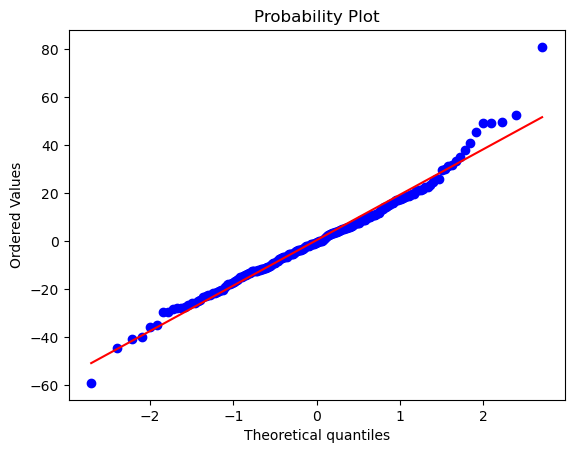

p-value from the shapiro-wilks test: 0.003950432408601046
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.11901487944538326
The p value of the runs test does not indicate significant evidence against random


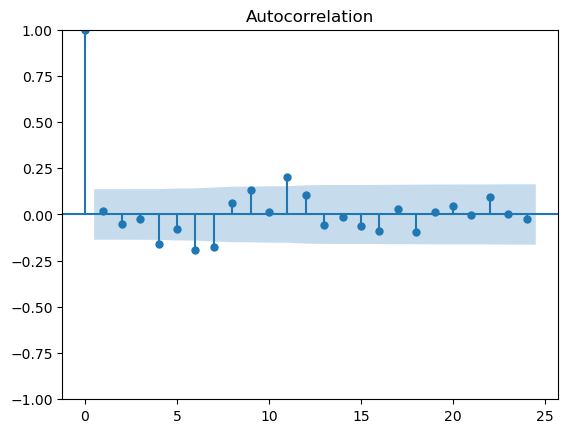

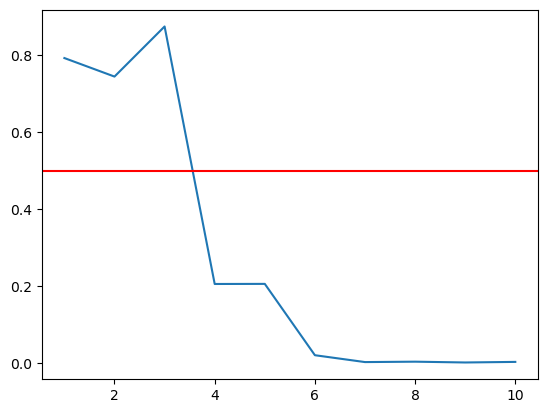

Results from Ljung-Box Test: 

      lb_stat  lb_pvalue
1    0.069511   0.792050
2    0.591483   0.743980
3    0.696492   0.874029
4    5.914982   0.205588
5    7.204897   0.205842
6   14.945955   0.020681
7   21.710638   0.002849
8   22.611074   0.003901
9   26.299344   0.001825
10  26.328018   0.003323


In [120]:
evaluate_residuals(resid_pmd)

The initial model found by pmd_arima has some uncaptured dependence in the data at lag 6 and on as indicated by statistically significant results in the Ljung-Box Test. This indicates that the model may not be a good fit for the data that is here. To correct this we can try to add the MA(1) parameter as suggested by the auto-correlation plot.

In [124]:
model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(3,1,1), seasonal_order=(3,1,1,10), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())

resid_pmd = res_pmd.resid
preds = res_pmd.predict(1,235)

                                     SARIMAX Results                                      
Dep. Variable:                               mean   No. Observations:                  205
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 10)   Log Likelihood                -820.634
Date:                            Wed, 12 Apr 2023   AIC                           1659.268
Time:                                    14:40:26   BIC                           1688.679
Sample:                                         0   HQIC                          1671.177
                                            - 205                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1133      0.086     12.877      0.000       0.944       1.283
ar.L2         -0.3327      0.102   

C:\Users\Theodore Steffens\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


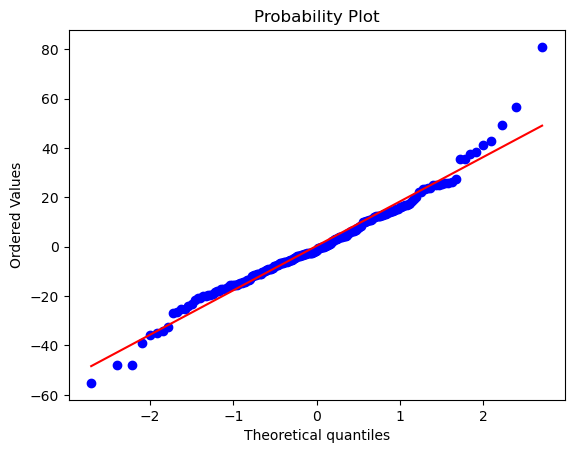

p-value from the shapiro-wilks test: 0.0005475800717249513
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.22341494720456212
The p value of the runs test does not indicate significant evidence against random


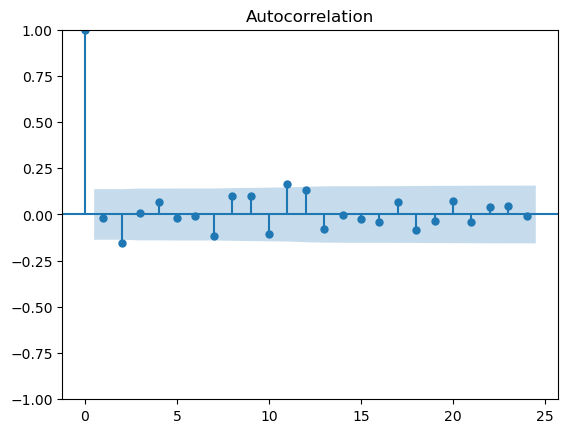

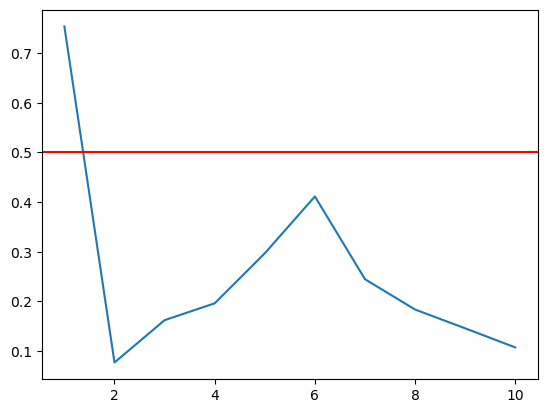

Results from Ljung-Box Test: 

      lb_stat  lb_pvalue
1    0.098483   0.753657
2    5.126550   0.077052
3    5.133666   0.162267
4    6.039664   0.196206
5    6.097100   0.296885
6    6.106550   0.411361
7    9.111765   0.244731
8   11.330979   0.183641
9   13.388289   0.145809
10  15.738483   0.107367


In [125]:
evaluate_residuals(resid_pmd)

From the analysis we can see that there is no longer uncaptured dependance in the data as indicated by significant values in the Ljung Box test. We can then say that we have captured all of the dependance available in the dataset. We also can see that the AIC is a bit lower than that of the suggested model from pmd_arima, however there is a small penalty to the BIC.

Next we can try to forecast the remaining 30 data points to see how well the model is able to do that.

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205    15.123535  15.702498     -15.652795      45.899866
206    35.370276  24.856394     -13.347362      84.087913
207    66.411524  30.699933       6.240761     126.582287
208   100.094563  32.931274      35.550452     164.638674
209   108.821641  33.270675      43.612317     174.030965


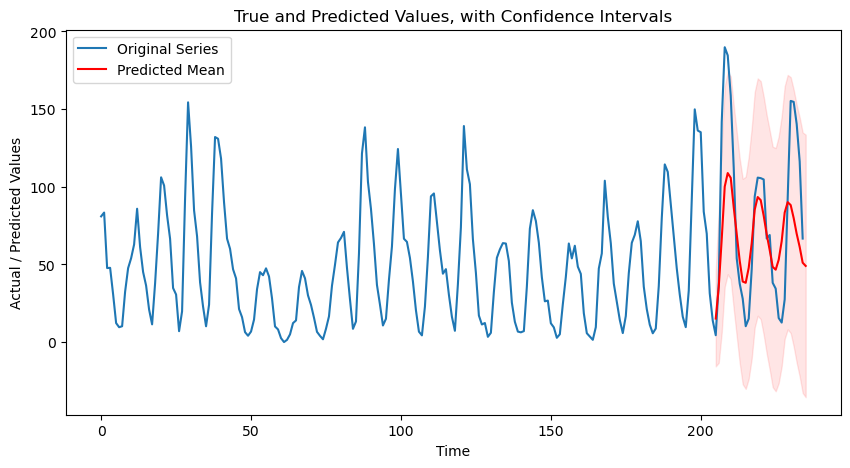

In [126]:
preds_df = (res_pmd
            .get_prediction(start=205, end=235)
            .summary_frame(alpha=0.05)
)
print(preds_df.head())

# Plot the training data, predicted means and confidence intervals
fig, ax = plt.subplots(figsize=(10,5))
ax = yearly_spots.plot(label='Original Series')
ax.set(
    title='True and Predicted Values, with Confidence Intervals',
    xlabel='Time',
    ylabel='Actual / Predicted Values'
)
preds_df['mean'].plot(ax=ax, style='r', label='Predicted Mean')
ax.fill_between(
    preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
    color='r', alpha=0.1
)
legend = ax.legend(loc='upper left')

Here we can see that the forecasting for the first few years out is doing quite well at predicting the trend, however as the time scale moves farther away the prediction begins to collapse to the mean losing some forecasting power. It is important to keep in mind that by the end of the forecasting period this is looking 30 years into the future which is quite some time out.